In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import multiprocessing as mp
import random

#from utils import Labels

In [2]:
# Define path names here
image_path_prefix = 'data/Category and Attribute Prediction Benchmark/Img/Img/'
image_to_category = 'data/Category and Attribute Prediction Benchmark/Anno/list_category_img.txt'
img_net_class_path = 'data/ImageNetClasses/imagenet1000_clsid_to_human.txt'
deep_fash_class_path = 'data/Category and Attribute Prediction Benchmark/Anno/list_category_cloth.txt'

n_images_loaded = -1 # -1 loads all

In [ ]:
## Load the classifiers
from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

res50 = ResNet50(weights='imagenet')
incv3 = InceptionV3(weights='imagenet')
xcept = Xception(weights='imagenet')

model_dict = {
        'resnet' : res50,
        'inception_v3' : incv3,
        'xception' : xcept,
    }

#for name, model in model_dict.items():
    

In [2]:
from keras.applications.resnet50 import ResNet50

# This thing is a major memory hog. Each image gets copied
# multiple (3?) times and a copy of the model instances must 
# be loaded for each process
# That'll be really slow too. Need a way to share model between processes
# This: https://stackoverflow.com/questions/25477470
# seems to say I can use a manager class, but need to be careful what's in
# my global namespace and not touch too much as copy-on-write can still 
# raise mem requirements
class ImageSegmenterFactory():
    """
    Stores configuration information for ImageSegmenters and allows
    processing a list of images in parallel using them
    """
#    __slots__ = ('null_pattern','n_super_pixels','compactness','max_iters')
    
    def __init__(self,null_pattern,n_super_pixels,compactness,
                 low_threshold=1e-8,high_threshold=100,max_iters=10,
                 max_regions=100):
        """
        null_pattern - Image that replaces the portions of the segmented image deemed irrelevant
        n_super_pixels - Roughly translates to the number of super pixels normalized cuts acts on
        compactness - The larger this is the more spatially localized super pixels are
        low_threshold - The threshold argument for sklearns's cut_normalized_gen will not dip below this
        high_threshold - The threshold argument for sklearns's cut_normalized_gen will not go above this
        max_iters - The number of times to refine the run cut_normalized_gen's
        """
        self.config = {
            'null_pattern' : null_pattern,
            'n_super_pixels' : n_super_pixels,
            'compactness' : compactness,
            'low_threshold' : low_threshold,
            'high_threshold' : high_threshold,
            'max_iters' : max_iters,
            'max_regions' : max_regions,
        }
# Low threshold:
# If multiple regions or no regions identified threshold is too large
# If single region identifiable, drop irrelevant portions and make threshold larger

# High threshold:
# If ablative segmentation does not kill classification threshold too high
# If ablative segmentation does kill it threshold too low
    @staticmethod
    def get_pixel_mask(model_path,image_preproc,config,image):
        model = ImageSegmenterFactory.load_model(model_path)
        segmenter = ImageSegmenter(model,image_preproc,config,image)
        segmenter.segment_image()
        return segmenter.pixel_mask
    
    @staticmethod
    def load_model(model_path):
        if model_path == 'resnet':
            return res50
        raise NotImplementedError
    
    def segment_images(self,model_path,image_preproc,images):
        num_cpus = mp.cpu_count()
        proc_pool = mp.Pool(num_cpus - 1)
        
        #segment_masks = proc_pool.map(partial(self.get_pixel_mask,model_path,image_preproc,self.config),images)
        segment_masks = []
        for image in images:
            segment_masks.append(self.get_pixel_mask(model_path,image_preproc,self.config,image))
        return segment_masks

Using TensorFlow backend.


In [16]:
from skimage.segmentation import slic # produces integer mask
from skimage_contrib.skimage.future.graph import rag_mean_color, cut_normalized_gen

def show_image(img):
    # If there is a number greater than 1, divide by 255
    if img.max() > 1:
        imshow(img/255)
    else:
        imshow(img)
    plt.show()

class ImageSegmenter():
    """
    This class attempts to segment an image into object and non-object regions
    using a pretrained classifier to gauge the quality of its segmentation
    """
#    __slots__ = ('image','masked_image','null_pattern',
#                 'max_iters','pixel_mask','rag')
        
    def __init__(self,model,image_preproc,config,image):
        """Store the image info needed """
        self.model = model
        self.image_preproc = image_preproc
        
        # Can test misclassification effect by providing true class directly
        # and trying to segment based off that
        self.true_class, self.base_prob = self.predict_class(self.model,self.image_preproc,image.astype(np.float16))
        
        # Prepare segmentation info
        self.image = image # Will be iteratively masked
        self.pixel_mask = np.ones(image.shape[:2],dtype=bool) # False means use null pattern
        self.super_pixels = slic(image,config['n_super_pixels'],config['compactness'])
        self.rag = rag_mean_color(image, self.super_pixels, mode='similarity')
        self.cut_gen = cut_normalized_gen(self.super_pixels,self.rag,init_thresh=0)
        next(self.cut_gen)
        
        self.null_pattern = config['null_pattern']
        self.max_iters = config['max_iters']
        self.max_regions = config['max_regions']
        self.low_threshold = np.log10(config['low_threshold'])
        self.high_threshold = np.log10(config['high_threshold'])
        self.prob_thresh = .5
        self.area_thresh = .02
    
    def segment_image(self):
        """
        Calculate a pixel_mask specifying the location of the object in this 
        class' image. 
        """
        if self.true_class == -1:
            self.pixel_mask = np.zeros(self.image.shape,dtype=bool)
            return
        #self._raise_low_threshold()
        self._lower_high_threshold()
        self._clean_segmentation()
    
    @staticmethod
    def mask_image(image,null_pattern,pixel_mask):
        """
        Replaces masked portions of image with values of null_pattern.
        Last dimension must be channel. True values in mask mean show image. 
        """
        masked_image = (~pixel_mask.T*null_pattern.T).T + \
                         (pixel_mask.T*image.T).T
        return masked_image
    
    @staticmethod
    def class_prob(model, image_preproc, image, class_ind):
        """
        Returns the predicted class for this image.
        
        Predicted class satisfies the criteria:
        - Has the highest predicted probability
        - Has a probability 1.5 times higher than expected from randomly guessing
        
        The 1.5 times value is arbitrary
        """
        #return (random.random()*2 + 1)//2
        
        image = image.copy()
        image = image_preproc(image)
        pred = model.predict(np.stack([image]))
        pred = np.ravel(pred)
        return pred[class_ind]
    
    @staticmethod
    def predict_class(model, image_preproc, image):
        """
        Returns the predicted class for this image.
        
        Predicted class satisfies the criteria:
        - Has the highest predicted probability
        - Has a probability 1.5 times higher than expected from randomly guessing
        
        The 1.5 times value is arbitrary
        """
        #return (random.random()*2 + 1)//2
        
        image = image.copy()
        image = image_preproc(image)
        pred = model.predict(np.stack([image]))
        pred = np.ravel(pred)
        pred_class = np.argmax(pred)
        
        if pred[pred_class] > 1.5*(1/len(pred)):
            return pred_class, pred[pred_class]
        return -1, 0
        
    @staticmethod
    def _adjust_threshold(threshold,cur_thresh,too_high,inc_rate,overshot):
        """
        Adjust the lower threshold in a way that ensures we never attempt the same threshold twice
        and iteratively approach the threshold yielding the smallest segmentation the
        classifier still recognizes as the correct object
        """
        if too_high: # Don't jump above the lower bound so much
            inc_rate = inc_rate/2
            overshot = True
        elif overshot: # Raise the lower bound but decrease the inc_rate
            threshold = cur_thresh
            inc_rate = inc_rate/2 # If we didn't lower inc_rate we'd be repeating a value
        else: # Raise the lower bound
            threshold = cur_thresh
        return threshold, inc_rate, overshot
        
    def _raise_low_threshold(self):
        """
        This function attempts to raise the low_threshold limit to 
        limit the areas in the picture considered part of the object
        """
        inc_rate = 1; overshot = False
        for i in range(self.max_iters):
            cur_thresh = self.low_threshold + inc_rate
            norm_cuts = self.cut_gen.send(10**cur_thresh)
            print('Cut {} at {}'.format(i, cur_thresh))
            too_high = self._narrow_regions(norm_cuts)
            self.low_threshold, inc_rate, overshot = self._adjust_threshold(self.low_threshold,cur_thresh,
                                                                            too_high,inc_rate,overshot)
        # Lock in the most refined pixel_mask found
        self.image = self.mask_image(self.image,self.null_pattern,self.pixel_mask)

    def _lower_high_threshold(self):
        """
        This function attempts to lower the high_threshold limit to
        shave off the small regions that don't belong to the object
        but get lumped together with it.
        
        Note that the image super pixels and rag are not recalculated -
        we do not want the null pattern to blend with the image. 
        """
        dec_rate = 1; overshot = False
        # If no iters or unable to refine high_threshold, relevant regions are True pixel_mask entries
        norm_cuts = self.pixel_mask
        for i in range(self.max_iters):
            cur_thresh = self.high_threshold - dec_rate
            norm_cuts = self.cut_gen.send(10**cur_thresh)
            
            # Only attempt refining if there aren't too many regions
            if len(np.unique(norm_cuts)) > self.max_regions:
                too_low = False
            else:
                too_low = True
            self.high_threshold, dec_rate, overshot = self._adjust_threshold(self.high_threshold,cur_thresh,
                                                                             too_low,dec_rate,overshot)
        print(len(np.unique(norm_cuts)))
        print(self.pixel_mask.all())
        relevant_regions = self._refine_regions(norm_cuts)
                
        # Lock in the most refined pixel_mask found. It's safe to zero the 
        # mask because previously excluded regions will not be in 
        # the best_relevant_regions list
        self.pixel_mask = np.zeros(self.pixel_mask.shape,dtype=bool)
        for r in relevant_regions:
            self.pixel_mask = self.pixel_mask | (norm_cuts == r)
        
    def _narrow_regions(self,norm_cuts):
        """
        Test each normalized cuts region to see if the classifier recognizes it as
        the correct class. 
        """
        norm_cuts = self.pixel_mask * (norm_cuts + 1) # Ignore regions deemed irrelevant
        relevant_regions = []
        print(np.unique(norm_cuts))
        for r in np.unique(norm_cuts):
            # Skip the nulled region
            if r == 0:
                continue
            # Consider only the current region
            cut_mask = (norm_cuts == r)
            masked_image = self.mask_image(self.image, self.null_pattern, cut_mask)
            show_image(masked_image)
            prob  = self.class_prob(self.model, self.image_preproc,
                                    masked_image.astype(np.float16), self.true_class)
            if self.get_relevancy(prob, cut_mask, large_region=True):
                relevant_regions.append(r)
        if len(relevant_regions) == 1:
            # Don't use intersection in case correct region area fluctuates
            # and region grows too small
            self.pixel_mask = (norm_cuts == relevant_regions[0])
            return False
        return True

    def _refine_regions(self,norm_cuts):
        """
        If removing a region causes a misclassification that region
        is deemed part of the object and we have segments that are too
        big. 
        
        I expect this will cause the object to be seen as only small
        chunks. A more accurate (and more computationally efficient) approach
        might be to do the region narrowing and then slightly oversegment from 
        there. Will attempt this first. 
        """
        norm_cuts = self.pixel_mask * (norm_cuts + 1) # Ignore regions deemed irrelevant
        relevant_regions = []
        for r in np.unique(norm_cuts):
            # Skip the nulled region
            if r == 0:
                continue
            # Remove only the considered region (and the area already deemed irrelevant)
            cut_mask = (norm_cuts != r)
            masked_image = self.mask_image(self.image, self.null_pattern, cut_mask)
            prob = self.class_prob(self.model, self.image_preproc,
                                   masked_image.astype(np.float16), self.true_class)
            if self._is_relevant(prob, cut_mask):
                relevant_regions.append(r - 1)
                show_image(masked_image)
        return relevant_regions

    def _is_relevant(self, prob, cut_mask):
        ## Some simple criteria. Making up more fine-grained rules
        ## would help. Large area with totally negligible change for
        ## instance. Would be best to optimize the thresholds on an
        ## image subset later. 

        # Classify the region types (range: [0,1])
        area_fraction = (~cut_mask).sum()/len(np.ravel(cut_mask))
        large_area = area_fraction > self.area_thresh
        
        # Classify the probability types (range: [0,x])
        # x = max((1 - base_prob)/base_prob, 1)
        relative_change = abs(self.base_prob - prob)/self.base_prob
        large_change = relative_change > self.prob_thresh
        print(area_fraction, relative_change)
        
        # Small areas always kept and large areas 
        # only excluded if the change is large enough
        return (not large_area or large_change)

    def _clean_segmentation(self):
        """
        Attempts to remove small gaps in the pixel mask to make the image segmentation look
        more natural.
        """
        pass

In [45]:
ImageSegmenter.predict_class(res50,res_preproc, np.zeros((224,224,3)))

916

In [4]:
from skimage.color import label2rgb
from skimage.io import imread, imshow
from skimage.transform import rescale
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as res_preproc

def preprocess_data(image):
    image = first_dim_224(image)
    image = pad_with_black(image)
    return image

def first_dim_224(img):
    """Scale first dimension of image to 224 pixels"""
    height = img.shape[0]
    return rescale(img,224/height,mode='constant', preserve_range=True)

def pad_with_black(img):
    """
    If image's x dim is less than 224 pixels pad with black. If too large crop to 224.
    Modification spread evenly across both sides.
    """
    pix_to_pad = 224 - img.shape[1]
    if pix_to_pad < 0:
        # Crop the image
        pix_to_crop = -pix_to_pad
        img = img[:,pix_to_crop//2:-((pix_to_crop+1)//2),:]
    else:
        # Pad the image
        img = np.pad(img,[(0,0),((pix_to_pad+1)//2,pix_to_pad//2),(0,0)],mode='constant')
    return img

res50 = ResNet50(weights='imagenet')
image = imread('gret_test.jpg')
#image = imread('dog_test.jpeg')

image = preprocess_data(image)
img = np.copy(image)
proc_image = res_preproc(image.astype(np.float64))

In [27]:
(image == img).all()

True

In [47]:
from keras.models import Model
from keras.layers import Lambda, InputLayer

inp = InputLayer(image.shape)
y = Lambda(new_preproc)(inp.output)
mod = Model(inp.input,y)

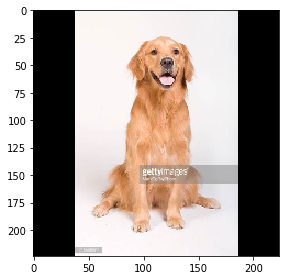

In [5]:
show_image(image)

In [17]:
np.argmax(res50.predict(np.stack([image])))

111

In [6]:
segmenter = ImageSegmenterFactory(np.zeros(image.shape,dtype=np.uint8),1000,100,
                 low_threshold=1e-8,high_threshold=100,max_iters=8, max_regions=50)

40
0.0848214285714 0.0
0.0832669005102 0.08633
0.135164221939 0.175028
0.0825892857143 0.0
0.00418526785714 0.188061


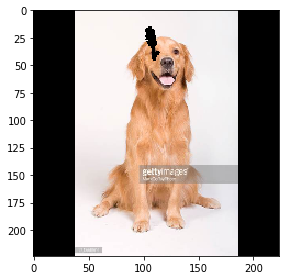

0.00679607780612 0.300552


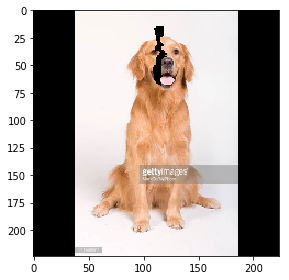

0.00193319515306 0.0034061


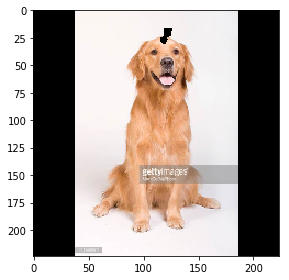

0.0875318877551 0.849102


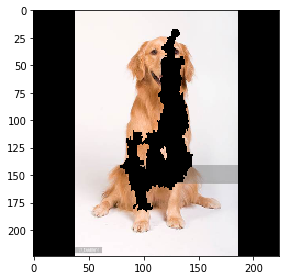

0.00986527423469 0.0312266


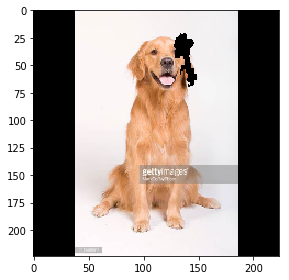

0.00757334183673 0.0881197


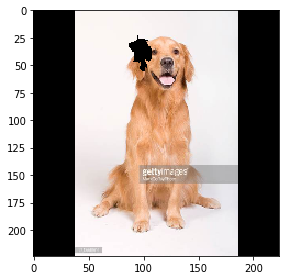

0.00161431760204 0.135024


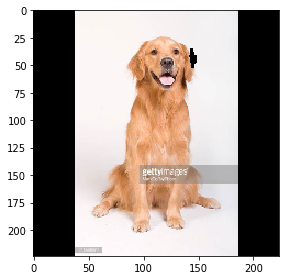

0.00538105867347 0.10908


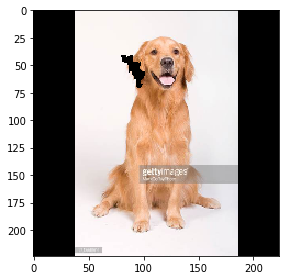

0.0111407844388 0.10464


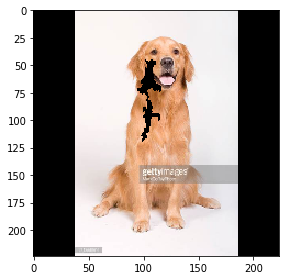

0.00320870535714 0.164981


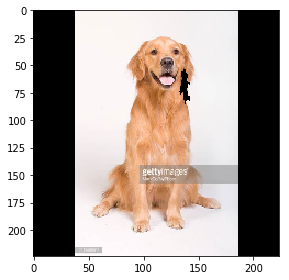

0.00372688137755 0.0185532


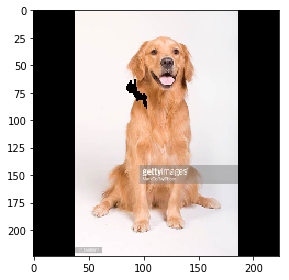

0.0749162946429 0.142837
0.00310905612245 0.129417


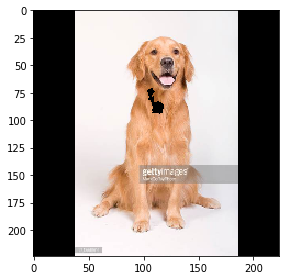

0.00109614158163 0.103629


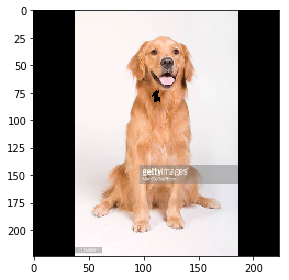

0.00789221938776 0.188246


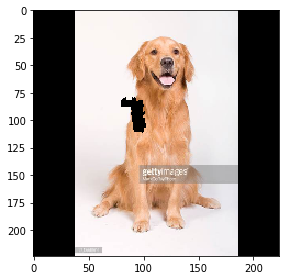

0.00420519770408 0.0874062


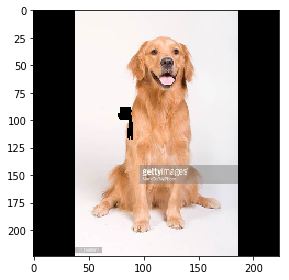

0.00191326530612 0.00525199


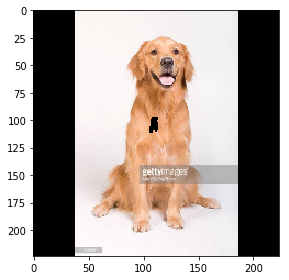

0.00271045918367 0.0745747


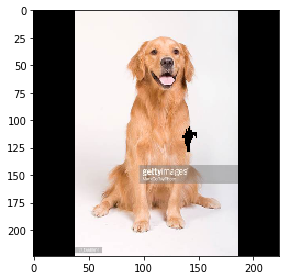

0.0848214285714 0.0
0.0825892857143 0.0
0.00296954719388 0.115767


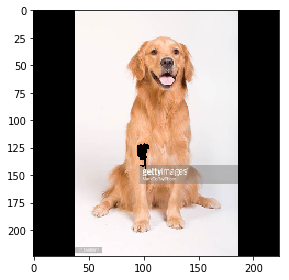

0.000797193877551 0.0118686


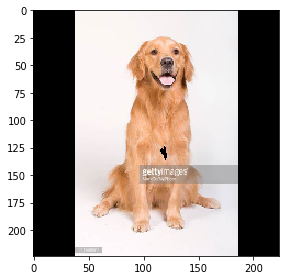

0.0133131377551 0.0963394


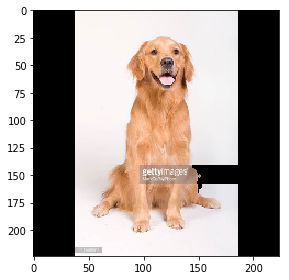

0.0160036670918 0.0895564


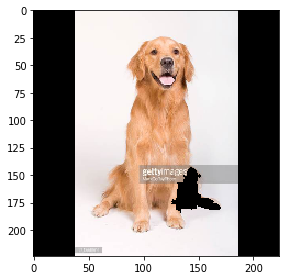

0.0009765625 0.0762058


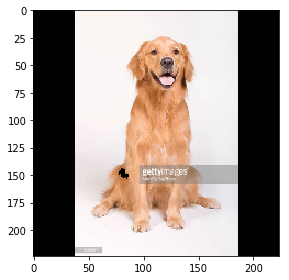

0.0155054209184 0.0449935


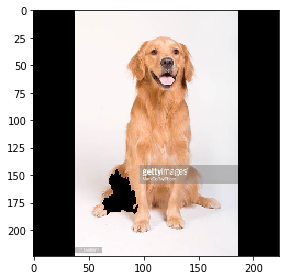

0.00332828443878 0.0567747


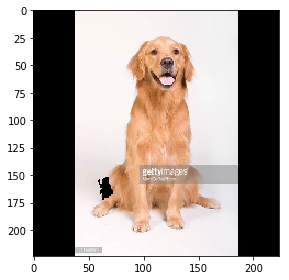

0.0130540497449 0.151186


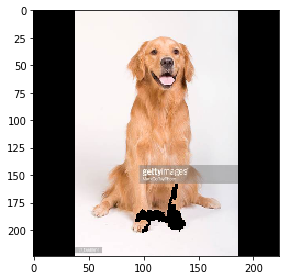

0.124103156888 0.0286497
0.00653698979592 0.0467311


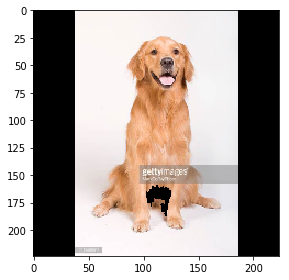

0.00107621173469 0.0809483


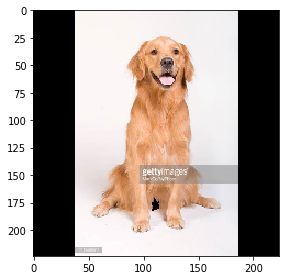

0.00081712372449 0.0315297


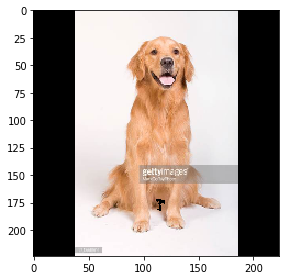

0.00253109056122 0.0409449


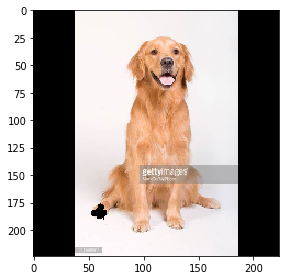

0.0032884247449 0.0285362


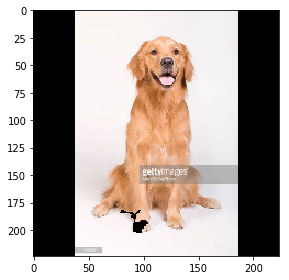

0.00065768494898 0.0173798


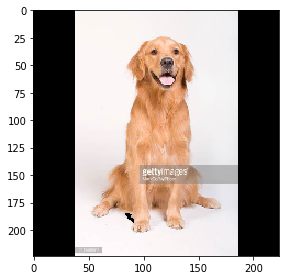

0.00298947704082 0.00177112


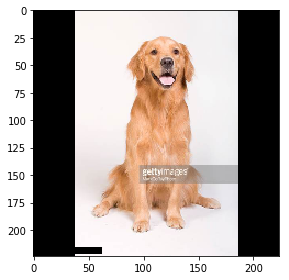

True


In [14]:
# Compare mask area to change in probability. 
# Large area with small change means irrelevant
# Large area with large decrease means relevant
# Small area with large change means relevant
# Small area with small change, leave it alone
pix_mask = segmenter.segment_images('resnet',res_preproc,[image])

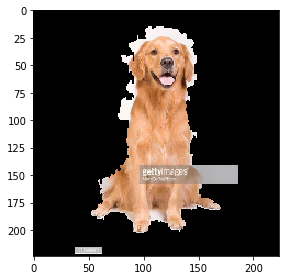

In [17]:
show_image((pix_mask[0].T*image.T).T)

In [72]:
from skimage.segmentation import slic # produces integer mask
from skimage.future.graph import rag_mean_color, cut_normalized
from skimage.color import label2rgb
from skimage.io import imread, imshow

#image = imread('test_img.jpg')
pixel_mask = slic(image,1000,100)
rag = rag_mean_color(image, pixel_mask, mode='similarity')
cn = cut_normalized(pixel_mask,rag,init_thresh=7.5e-2,in_place=False)

# region_labeled = label2rgb(sup_pixels, image, kind='avg')
# imshow(region_labeled)
# plt.show()

In [87]:
edge_vals = np.zeros(len(rag.edges()))
for i, e in enumerate(rag.edges()):
    edge_vals[i] = rag.get_edge_data(*e)['weight']

In [100]:
thresh = 1e-20
len_list = []
cut_gen = cut_normalized_gen(pixel_mask,rag,init_thresh=thresh)
next(cut_normalized_gen)
for i in range(25):
    cn = cut_normalized.send(thresh)
    thresh *= 10
    len_list.append((thresh,len(np.unique(cn))))

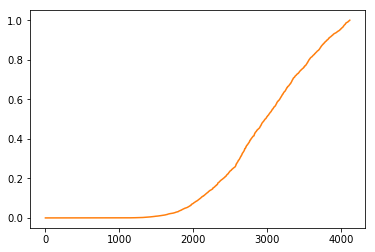

In [116]:
plt.plot(np.sort(edge_vals))
plt.show()

(25, 2)


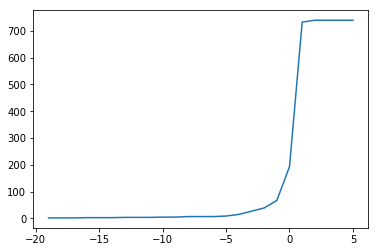

In [109]:
len_arr = np.array(len_list)
print(len_arr.shape)
plt.plot(np.log10(len_arr[:,0]),len_arr[:,1])
plt.show()

In [88]:
edge_vals.min()

4.052683705439187e-127

In [99]:
len(np.unique(cn))

1

In [149]:
cn.shape

(285, 250)

/Users/magee/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


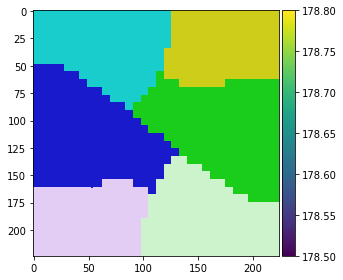

In [73]:
region_labeled = label2rgb(cn, np.zeros(image.shape) + 255, kind='overlay')
#region_labeled = label2rgb(cn, image, kind='avg')
imshow(region_labeled)
plt.show()

In [63]:
edge_count = 0
for l in rag.adjacency_list():
    edge_count += len(l)
edge_count

8228

In [20]:
np.copy(np.unique(np.array([[1,2],[3,1]])))

array([1, 2, 3])

In [ ]:
## Create a bool mask for each image and class following the algorithm described in the proposal


In [ ]:
## Compare the bounding boxes from the masks to reference bounding boxes
# Intersection over Union

# Center Correctness